In [30]:
import import_ipynb
import netsquid as ns
import numpy as np
import math
import matplotlib.pyplot as plt
from netsquid.components import QuantumChannel
from netsquid.components.models.qerrormodels import FibreLossModel
from IonTrap import IonTrap
from programs import emit_prog
from NoiseModels import CollectiveDephasingNoiseModel

In [31]:
"""Validate that emission success probability from an ion trap is as expected."""


def setup(collection_efficiency, fiber_length, attenuation):

    ion_trap = IonTrap(num_positions=1, collection_efficiency=collection_efficiency)

    loss_model = FibreLossModel(p_loss_length=attenuation, p_loss_init=0)
    fiber = QuantumChannel(name="fiber", length=fiber_length,
                           models={"quantum_loss_model": loss_model},
                           transmit_empty_items=True)
    fiber.ports["send"].connect(ion_trap.ports["qout"])
    collection_port = fiber.ports["recv"]

    # collection_port = ion_trap.ports["qout"]

    return ion_trap, collection_port

In [32]:

# ns.logger.setLevel(logging.DEBUG)

# x = np.arange(0.1, 1, 0.1)
# xstring = "collection efficiency"

x = range(1, 10)
xstring = "fiber length"

collection_efficiency = 1
fiber_length = 1
attenuation = 0.25

success_probs = []
success_prob_errors = []
expected_success_probs = []

for fiber_length in x:

    ion_trap, collection_port = setup(collection_efficiency=collection_efficiency,
                                      fiber_length=fiber_length,
                                      attenuation=attenuation)
    fail_count = 0
    num_tries = 500
    outcomes = []
    for _ in range(num_tries):
        ion_trap.execute_program(emit_prog)
        ns.sim_run()
        emitted_message = collection_port.rx_output()
        emitted_qubit = emitted_message.items[0]
        if emitted_qubit is None:
            outcomes.append(0)
        else:
            if emitted_qubit.qstate is None:
                outcomes.append(0)
            else:
                outcomes.append(1)

    success_prob = np.mean(outcomes)
    success_probs.append(success_prob)
    success_prob_error = np.std(outcomes) / math.sqrt(len(outcomes))
    success_prob_errors.append(success_prob_error)
    expected_success_prob = collection_efficiency * np.power(10, - attenuation * fiber_length / 10)
    expected_success_probs.append(expected_success_prob)

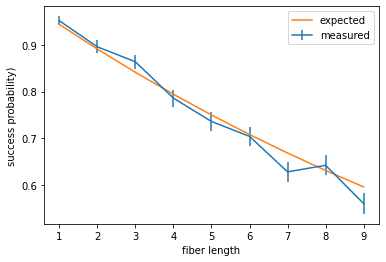

In [33]:
plt.figure()
plt.errorbar(x, y=success_probs, yerr=success_prob_errors, label="measured")
plt.plot(x, expected_success_probs, label="expected")
plt.xlabel(xstring)
plt.ylabel("success probability)")
plt.legend()
plt.show()